#### This code is for running the UFS Prototype 8 S2S Forecast data within the ellipse calculation code.

At the end is a sample timeseries plot of these calculated elliptical metrics. 

I do not call any specific ellipse metric .py file in here. 

In [1]:
##imports for relevant packages 

import datetime as dt
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import cartopy.feature
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
import xarray as xr
import math
import netCDF4
#from get_ellipse_metrics import get_emetrics_max_min
from fitEllipse2_new import fitEllipseContour
#from EllipseCalc import ellipse_calc
from geopy.distance import great_circle
from matplotlib.patches import Polygon
from matplotlib import cm #colormaps!
import copy
import os
import scipy.stats
import pickle
import matplotlib.ticker as mticker

In [2]:
#### Define functions first:
def point_inside_polygon(x,y,xarr,yarr):

	n = len(xarr)
	inside =False

	p1x = xarr[0]
	p1y = yarr[0]
	for i in range(n+1):
		p2x,p2y = xarr[i % n],yarr[i % n]
		if y > min(p1y,p2y):
			if y <= max(p1y,p2y):
				if x <= max(p1x,p2x):
					if p1y != p2y:
						xinters = (y-p1y)*(p2x-p1x)/(p2y-p1y)+p1x
					if p1x == p2x or x <= xinters:
						inside = not inside
		p1x,p1y = p2x,p2y

	return inside;

In [3]:
home_dir = '/home11/grad/2020/ef935217/Research/Dissertation/AI_Paper/Forecast_comparison' # Define your home working directory
lev_list = [10] #Define your list of hPa levels
temp_lev = [850] #Define your temperature level in hPa
#contour_list = [31500,20000,23000]
contour_list = [30000] #Define your list of contours relevant to hPa measures
windlat = 60.0 #Define latitude for zonal-mean winds
write_out = True #write the ellipse data to a text file, True or False 

forecast_length = 36 #number of days for UFS forecast
number = 5 #number of prototypes +era5

In [4]:
#test open UFS file
gfile = xr.open_dataset("/network/rit/lab/wulab/forecast/s2s/ufs/Prototype5/gh/gh_plevs_20111215.nc")
g_files = gfile["gh"]
g_files
#test = g_files.loc[dict(latitude=slice(90,0),lev=lev_list)]
#test

<xarray.DataArray 'gh' (time: 36, lev: 5, latitude: 721, longitude: 1440)>
[186883200 values with dtype=float32]
Coordinates:
  * lev        (lev) float64 500.0 300.0 100.0 50.0 10.0
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 2011-12-15 2011-12-16 ... 2012-01-19
Attributes:
    units:      gpm
    long_name:  Geopotential height

In [5]:
##create arrays for the elliptical metrics 
rat10 = np.empty((number,forecast_length))
wind10 = np.empty((number,forecast_length))
cenlat10 = np.empty((number,forecast_length))
cenlon10 = np.empty((number,forecast_length))
size10 = np.empty((number,forecast_length))
ep10 = np.empty((number,forecast_length))
num10 = np.empty((number,forecast_length))

In [6]:
#Start with defining desired period of record
year = 2011
month = 12
day = 15
date1 = dt.datetime(year,month,day,0)  #first date to plot
total_days = 36
first_fhr = 0
hours = total_days * 24
hr_inc = 24
times = [date1 + dt.timedelta(hours=x) for x in range(0,hours,hr_inc)]
date_list = netCDF4.date2num(times,units="hours since 1800-01-01 00:00:00",calendar="gregorian") #change dates to netcdf times

prototype = ["Prototype5","Prototype6","Prototype7","Prototype8"]

In [7]:
for plot_lev,the_contour in zip(lev_list,contour_list): #loop through each level
    print("Opening ECMWF data "+str(plot_lev)+" and contour level "+str(the_contour))
    ens_mem = [1,2,3,4] #indicate model Protoypes
    
    for mm in range(len(ens_mem)):
        member = ens_mem[mm]
        print("AHHHHHH "+str(mm))
        rat = []
        cenlt = []
        cenln = []
        wind = []
        sz = []
        ep = []
        number = []

        if plot_lev == 10:
            gfile = xr.open_dataset("/network/rit/lab/wulab/forecast/s2s/ufs/"+str(prototype[mm])+"/gh/gh_plevs_20111215.nc")
            g_files = gfile["gh"]
            tfile = xr.open_dataset("/network/rit/lab/wulab/forecast/s2s/ufs/"+str(prototype[mm])+"/t/t_plevs_20111215.nc")
            t_files = tfile["t"]
            ufile = xr.open_dataset("/network/rit/lab/wulab/forecast/s2s/ufs/"+str(prototype[mm])+"/u/u_plevs_20111215.nc")
            u_files = ufile["u"]
            
            print("Partitioning and averaging data.")
            print("First, g data")
            g_data = g_files.loc[dict(latitude=slice(90,0),lev=lev_list)]
            print("u data")
            u_data = u_files.loc[dict(latitude=slice(windlat+1,windlat-1),lev=lev_list)].mean(dim='longitude')
            print("t data")
            t_data = t_files.loc[dict(latitude=slice(90,75),lev=lev_list)]
            tlats = t_data['latitude'].values
            weights=np.cos(np.deg2rad(t_data.latitude))
            weights.name = "weights"
            
            print("lat and lon")
            lats_era = g_data["latitude"].values
            lons_era = g_data["longitude"].values
        
        for date in date_list: #loop through each day 
            print(f"date: {date_list}")
            ind = np.where(date_list == date)[0]
            for d in ind:
                t = d
                height = g_data.loc[dict(time=times[t],lev=plot_lev)]
                u = u_data.loc[dict(time=times[t],lev=plot_lev)].mean(dim='latitude')
                tdata = t_data.loc[dict(time=times[t],lev=plot_lev)].mean(dim='longitude')   
                #tdata2 = t2_data.loc[dict(time=times[t])]
            temp = tdata.weighted(weights).mean(dim='latitude')
            
            print("t2data")
            formatted_date = times[t].strftime("%Y%m%d")
            emark = []
            eline = []
            cs_temp = []
            print("##########################")
            print(date)
            print("Date "+times[t].strftime("%H UTC %d %b %Y"))
            valid_label = (times[t].strftime("Valid: %H UTC %d %b %Y"))
            
            plt.Figure(figsize=(15,15),dpi=120)#figure(figsize=(12,12),dpi=1200) <---Set fig size here!
            #ax = plt.subplot(1,1,1,projection=ccrs.Orthographic(0,90))
            ax = plt.axes(projection=ccrs.Orthographic(0,90))
            ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='dimgray',facecolor='none')
            #ax.set_extent([-180,180,0,90],ccrs.PlateCarree())
            ax.outline_patch.set_edgecolor('none')
            gl = ax.gridlines(color="grey",linestyle=":",linewidth=0.5)#=lat_lon_width)
            
            clevs = range(18000,33500,250)
            [x,y] = np.meshgrid(lons_era,lats_era)
            #[x2,y2] = np.meshgrid(tlons_era,tlats_era)
            
            plt.title(str(plot_lev)+"hPa Elliptical Diagnostics\n"+valid_label)
            mem_color = "blue"
            mem_lw = 3.0
            mem_ms = 8
            cont_color = "#aec2e2"
            cont_lw = 1.0
            cs_temp.append(ax.contour(x,y,height,levels=clevs,linewidths=cont_lw,colors=cont_color))
            
            line_w = np.array(clevs,dtype=np.float)
            for i,c in enumerate(clevs):
                if c == the_contour:
                    line_w[i] = 1.5 # Make the contour we're using for the ellipse calc fatter
                else:
                    line_w[i] = 0.5
            print(clevs)
            
            ax.contour(x,y,height,clevs,transform=ccrs.PlateCarree(),extend='both',colors='black',linewidths=line_w)
            #ax.contour(x2,y2,tdata2, lev = [tmean], transform=ccrs.PlateCarree(),extend='both',colors='blue',linewidths=line_w)
            
            try:
                lev_contour_ind = np.where(np.array(cs_temp[-1].levels)==the_contour)[0][0]
                isoline_list = cs_temp[-1].allsegs[lev_contour_ind]
                print("in try")
                print("Number of ellipses: ",len(isoline_list))
            except:
                print("Contours not found for",the_contour,"meter level at",plot_lev,"hPa.")
                isoline_list = []
            
            if len(isoline_list) > 0:
                lev_contour_ind = np.where(np.array(cs_temp[-1].levels)==the_contour)[0][0]
                isoline_list = cs_temp[-1].allsegs[lev_contour_ind]
                #print(isoline_list)
                print("in elipse ...")
                print("Number of ellipses: ",len(isoline_list))
            else:
                print("Contours not found for",the_contour,"meter level at",plot_lev,"hPa.")
                isoline_list = []
            
            ##number of contours
            isocount = 0
            small = 0
            #empty lists for upcoming metric calculations
            ratio1 = []
            uvalues1 = []
            cenlat1 = []
            cenlon1 = []
            size1 = []
            ephi1 = []
            
            for isoline in isoline_list:
                ##next few lines will check if the contour crossing the prime meridian is one continuous contour or two separate ones
                #print('isoline',isoline)
                #[iso_lon,iso_lat] = mm(isoline[:,0],isoline[:,1],inverse=True)
                [iso_lon,iso_lat] = [isoline[:,0],isoline[:,1]]
                if len(iso_lon)<15:
                    #print("-----Not analyzing ellipse with",len(iso_lon),"points, continuing...")  # Check for size!
                    small = 1
                    continue
                # Checking to see if contours are closed (0) or need to be joined (1)  Checking before convert lat/lon to radians
                lon_diff = abs(iso_lon[0] - iso_lon[len(iso_lon)-1])
                lat_diff = abs(iso_lat[0] - iso_lat[len(iso_lat)-1])
                join = 0
                if lon_diff > 1 or lat_diff > 1:
                    join = 1
                    #print("Diffs lat/lon: ",lat_diff,lon_diff)
                iso_lon = np.deg2rad(iso_lon)
                iso_lat = np.deg2rad(iso_lat)
                
                ex = np.array((np.cos(iso_lon)*np.cos(iso_lat))/(1+np.sin(iso_lat)))
                ey = np.array((np.sin(iso_lon)*np.cos(iso_lat))/(1+np.sin(iso_lat)))
                ## does this contour include the pole?
                overpole = point_inside_polygon(0,0,ex,ey)  #returns true if poly includes the pole, false if not 
                #print("It is",overpole, "that the contour includes the pole")
                if not overpole and len(isoline_list) > 1 and join > 0 and small < 1:
                    if isocount > 0:
                        ex = np.append(ex,ex2)
                        ey = np.append(ey,ey2)
                        #print("Point didn't include pole - add to these to previous set")
                    else:
                        ex2 = ex
                        ey2 = ey
                        #print("Point didn't include pole - keeping these to add to next set")
                        isocount = 1
                        continue
                ##begin actual calculation        
                #print("Running ellipse diagnostic now")
                exx,eyy,eaax,ebax,ecenterx,ecentery,ephi = fitEllipseContour(ex,ey)
                
                ## Convert back to lat/lon
                elons = np.where(exx<0,np.where(eyy>0,np.arctan(eyy/exx)+math.pi,np.arctan(eyy/exx)-math.pi),np.arctan(eyy/exx))
                yysinxxlon = eyy/np.sin(elons)
                elats = -2*(np.arctan(yysinxxlon) - (math.pi/4.0))
                elats = np.rad2deg(elats)
                elons = np.rad2deg(elons)
                
                ## Still not really sure what this is for...
                for g in range(1,len(elats)):
                    if abs(elats[g]-elats[g-1]) > 1.5:
                        elats[g] = elats[g-1]
                
                ## Center points back to lat/lon
                cenlon = np.where(ecenterx<0,np.where(ecentery>0,np.arctan(ecentery/ecenterx)+math.pi,np.arctan(ecentery/ecenterx)-math.pi),np.arctan(ecentery/ecenterx))
                ysinlon = ecentery/np.sin(cenlon)
                cenlat = np.rad2deg(-2 * (np.arctan(ysinlon) - (math.pi/4.0)))
                cenlon = np.rad2deg(cenlon)
                #print("Center of ellipse:",cenlat,"N",cenlon,"E")
                
                ## Calculate endpoints of the axes of the vortex, convert to lat/lon
                xa = eaax * np.cos(ephi)
                ya = eaax * np.sin(ephi)
                xb = ebax * np.sin(ephi)
                yb = ebax * np.cos(ephi)
                endx = np.array([ecenterx+xa,ecenterx-xa,ecenterx+xb,ecenterx-xb])
                endy = np.array([ecentery+ya,ecentery-ya,ecentery-yb,ecentery+yb])
                endlon = np.where(endx < 0,np.where(endy>0,np.arctan(endy/endx)+math.pi,np.arctan(endy/endx)-math.pi),np.arctan(endy/endx))
                ysinelon = endy/np.sin(endlon)
                endlat = np.rad2deg(-2 *(np.arctan(ysinelon) - (math.pi/4)))
                endlon = np.rad2deg(endlon)
                
                ## Calc great circle distances; (still necessary?) 
                a1gc = great_circle((endlat[0],endlon[0]),(cenlat,cenlon)).km
                a2gc = great_circle((cenlat,cenlon),(cenlat,endlat[1])).km
                b1gc = great_circle((endlat[2],endlon[2]),(cenlat,cenlon)).km
                b2gc = great_circle((cenlat,cenlon),(endlat[3],endlon[3])).km
                
                ephi = np.rad2deg(ephi)
                if a1gc < b1gc:
                    ephi -= 90
                    #print("Emetrics phi:",ephi)
                if ephi < -45:
                    ephi += 180
                ratio = a1gc/b1gc
                if ratio < 1.0:
                    ratio = 1.0/ratio
                size = math.pi*a1gc*b1gc
                estr = times[t].strftime("%H %Y%m%d%H")+" "+f'{cenlon:.3f}'+" "+f'{cenlat:.3f}'+" "+f'{a1gc:.3f}'+" "+f'{b1gc:.3f}'+" "+f'{ephi:.3f}'+" "+f'{u.values:.3f}'+" "+f'{temp.values:.3f}'
                
                exy=np.array(list(zip(elons,elats)))
                plt.plot(elons,elats,color='red',transform=ccrs.Geodetic(),linewidth=mem_lw)
                plt.plot(cenlon,cenlat,markersize=4,marker='o',color='red',transform=ccrs.PlateCarree())
                #ax.add_patch(Polygon(exy,closed=True,color='magenta',fill=False,lw=mem_lw,transform=ccrs.PlateCarree()))

                ##append values to the empty lists for this day/iteration
                ratio1.append(ratio)
                uvalues1.append(u.values)
                cenlat1.append(cenlat)
                cenlon1.append(cenlon)
                size1.append(size)
                ephi1.append(ephi)

            #check how many vortices and average is >= 1 and inout nan if 0
            if len(ratio1) >= 1:
                rat.append(np.mean(ratio1))
                wind.append(np.mean(uvalues1))
                cenlt.append(np.median(cenlat1))
                cenln.append(np.median(cenlon1))
                sz.append(np.mean(size1))
                ep.append(np.mean(ephi1))
                number.append(len(ratio1))
            
            if len(ratio1) == 0:
                rat.append(np.nan)
                wind.append(np.nan)
                cenlt.append(np.nan)
                cenln.append(np.nan)
                sz.append(np.nan)
                ep.append(np.nan)
                number.append(0)
        
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`")
        print("Ensemble #: "+str(mm))
        print(len(rat))
        print(rat)
        if plot_lev == 10:
            print('lev 10')
            rat10[mm]= rat[:]
            wind10[mm]= wind[:]
            cenlat10[mm]= cenlt[:]
            cenlon10[mm]= cenln[:]
            size10[mm]= sz[:]
            ep10[mm]= ep[:]
            num10[mm]= number[:]
        
        if plot_lev == 50:
            print('lev 50')
            rat50[mm]= rat[:]
            wind50[mm]= wind[:]
            cenlat50[mm]= cenlt[:]
            cenlon50[mm]= cenln[:]
            size50[mm]= sz[:]
            ep50[mm]= ep[:]
            num50[mm]= number[:]


Opening ECMWF data 10 and contour level 30000
AHHHHHH 0
Partitioning and averaging data.
First, g data
u data
t data
lat and lon
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1857936
Date 00 UTC 15 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.09050575 0.00393847]
old angle of rotation = 23.05975681718018
old axes = [0.29595994 0.42417089]
center = [0.09050575 0.00393847]
angle of rotation = -66.94024318281983
axes = [0.42417089 0.29595994]
0.42417088689834337 0.2959599362241554 0.09050575206939351 0.003938469160275945 -1.1683276456258944
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1857960
Date 00 UTC 16 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.09564059 0.01206807]
old angle of rotation = 22.950935229085577
old axes = [0.3001508  0.41604485]
center = [0.09564059 0.01206807]
angle of rotation = -67.04906477091443
axes = [0.41604485 0.3001508 ]
0.41604484614559994 0.3001507996680177 0.09564058991862823 0.012068072148584005 -1.1702269406353942
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1857984
Date 00 UTC 17 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.10340745 0.01043216]
old angle of rotation = 23.538703550190974
old axes = [0.30400223 0.40900618]
center = [0.10340745 0.01043216]
angle of rotation = 23.538703550190974
axes = [0.30400223 0.40900618]
0.3040022300424807 0.4090061844452432 0.10340745154169531 0.010432159905584677 0.41082787860171077
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858008
Date 00 UTC 18 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.10738686 0.00751524]
old angle of rotation = 25.451876960242807
old axes = [0.30111975 0.40991244]
center = [0.10738686 0.00751524]
angle of rotation = -64.5481230397572
axes = [0.40991244 0.30111975]
0.40991244329410775 0.30111975407527186 0.1073868579491086 0.007515241323246338 -1.1265772730261738
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858032
Date 00 UTC 19 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.10274518 0.01630243]
old angle of rotation = 24.998660678980965
old axes = [0.29285258 0.41651589]
center = [0.10274518 0.01630243]
angle of rotation = -65.00133932101905
axes = [0.41651589 0.29285258]
0.41651589345966955 0.29285258477318493 0.10274518075634115 0.01630243490948938 -1.1344873893578376
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858056
Date 00 UTC 20 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.09509725 0.04011475]
old angle of rotation = 25.259389731857862
old axes = [0.28279653 0.42376676]
center = [0.09509725 0.04011475]
angle of rotation = -64.74061026814215
axes = [0.42376676 0.28279653]
0.42376675711270173 0.282796533894636 0.0950972485868527 0.04011475492541995 -1.1299368089295294
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858080
Date 00 UTC 21 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.09175994 0.0696253 ]
old angle of rotation = 28.114764783856995
old axes = [0.28034603 0.42357723]
center = [0.09175994 0.0696253 ]
angle of rotation = -61.88523521614301
axes = [0.42357723 0.28034603]
0.4235772281673829 0.28034602934557407 0.09175993735378539 0.06962530167979551 -1.0801011128928402
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858104
Date 00 UTC 22 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.09744158 0.08804759]
old angle of rotation = 31.641215336900444
old axes = [0.2811401  0.42464772]
center = [0.09744158 0.08804759]
angle of rotation = -58.358784663099556
axes = [0.42464772 0.2811401 ]
0.4246477195460445 0.28114010007856877 0.09744158169207649 0.0880475882371213 -1.018552939833457
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858128
Date 00 UTC 23 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.11159473 0.08978117]
old angle of rotation = 33.57823639215705
old axes = [0.28137968 0.4276345 ]
center = [0.11159473 0.08978117]
angle of rotation = -56.42176360784295
axes = [0.4276345  0.28137968]
0.4276344995803772 0.2813796832835348 0.11159472918702286 0.08978116953712585 -0.9847455447387742
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858152
Date 00 UTC 24 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.12965708 0.07768446]
old angle of rotation = 32.213525573334095
old axes = [0.27972767 0.42885308]
center = [0.12965708 0.07768446]
angle of rotation = -57.78647442666591
axes = [0.42885308 0.27972767]
0.4288530819211506 0.27972767236208557 0.12965708318236405 0.07768446224454746 -1.0085642418648226
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858176
Date 00 UTC 25 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.14295798 0.06607825]
old angle of rotation = 30.733179084212193
old axes = [0.26959354 0.43051503]
center = [0.14295798 0.06607825]
angle of rotation = -59.266820915787804
axes = [0.43051503 0.26959354]
0.4305150289434783 0.2695935393535604 0.14295797630039123 0.06607824951441096 -1.0344011621703382
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858200
Date 00 UTC 26 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.14494279 0.06753537]
old angle of rotation = 32.6826871484927
old axes = [0.25480924 0.43537326]
center = [0.14494279 0.06753537]
angle of rotation = 32.6826871484927
axes = [0.25480924 0.43537326]
0.254809243307019 0.43537325962224943 0.14494278607701444 0.06753537249042961 0.5704204991404345
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858224
Date 00 UTC 27 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.14108315 0.07987845]
old angle of rotation = 38.02910644126845
old axes = [0.24436699 0.43842361]
center = [0.14108315 0.07987845]
angle of rotation = 38.02910644126845
axes = [0.24436699 0.43842361]
0.2443669906950394 0.43842360795722907 0.1410831451448315 0.07987844868360991 0.6637331189915181
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858248
Date 00 UTC 28 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.13687187 0.09590062]
old angle of rotation = 43.884243544656535
old axes = [0.24133053 0.42867107]
center = [0.13687187 0.09590062]
angle of rotation = -46.11575645534347
axes = [0.42867107 0.24133053]
0.42867106776060065 0.24133052907962887 0.1368718747048316 0.0959006231711389 -0.8048717871935729
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858272
Date 00 UTC 29 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.12823955 0.10868609]
old angle of rotation = -43.41348289501606
old axes = [0.42353613 0.23968957]
center = [0.12823955 0.10868609]
angle of rotation = -43.41348289501606
axes = [0.42353613 0.23968957]
0.4235361295753931 0.23968957037109392 0.12823955049395908 0.10868608750222825 -0.7577082162762699
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858296
Date 00 UTC 30 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.11322785 0.11559386]
old angle of rotation = -41.03251723944585
old axes = [0.42123262 0.23559097]
center = [0.11322785 0.11559386]
angle of rotation = 48.96748276055416
axes = [0.23559097 0.42123262]
0.2355909661341415 0.4212326214356111 0.11322785462382215 0.11559385561811147 0.8546438005852321
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858320
Date 00 UTC 31 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.1003536  0.11537689]
old angle of rotation = -36.31145238041989
old axes = [0.4152462  0.23176921]
center = [0.1003536  0.11537689]
angle of rotation = -36.31145238041989
axes = [0.4152462  0.23176921]
0.4152462012347959 0.23176920932550088 0.10035359849979616 0.1153768948071128 -0.6337544002194596
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858344
Date 00 UTC 01 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.08537799 0.11081543]
old angle of rotation = -31.131453126168616
old axes = [0.40610795 0.23091417]
center = [0.08537799 0.11081543]
angle of rotation = -31.131453126168616
axes = [0.40610795 0.23091417]
0.4061079453852677 0.23091416851417088 0.08537798834386462 0.11081542622232096 -0.543346357981924
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858368
Date 00 UTC 02 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.07848447 0.10169745]
old angle of rotation = -26.291024894135344
old axes = [0.3793964  0.23562495]
center = [0.07848447 0.10169745]
angle of rotation = -26.291024894135344
axes = [0.3793964  0.23562495]
0.3793964033079757 0.2356249455459627 0.07848447095403532 0.10169744561327147 -0.4588649481264554
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858392
Date 00 UTC 03 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.08112945 0.09163534]
old angle of rotation = -24.859099728227378
old axes = [0.34754288 0.24600991]
center = [0.08112945 0.09163534]
angle of rotation = -24.859099728227378
axes = [0.34754288 0.24600991]
0.347542877425146 0.2460099103445859 0.08112944957859597 0.09163533944778973 -0.4338731393391953
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858416
Date 00 UTC 04 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.08587997 0.08301213]
old angle of rotation = -34.721089637829856
old axes = [0.32402774 0.2548195 ]
center = [0.08587997 0.08301213]
angle of rotation = -34.721089637829856
axes = [0.32402774 0.2548195 ]
0.3240277409668126 0.2548195048107239 0.0858799720158589 0.08301212872019606 -0.6059973340602165
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858440
Date 00 UTC 05 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.09589365 0.07348386]
old angle of rotation = 40.336721163323425
old axes = [0.25003883 0.32993096]
center = [0.09589365 0.07348386]
angle of rotation = -49.66327883667658
axes = [0.32993096 0.25003883]
0.32993095665808075 0.2500388293877943 0.0958936548850129 0.07348386123538721 -0.8667877330360255
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858464
Date 00 UTC 06 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.10221899 0.06610261]
old angle of rotation = 36.54514222665371
old axes = [0.24004641 0.34929758]
center = [0.10221899 0.06610261]
angle of rotation = -53.45485777334629
axes = [0.34929758 0.24004641]
0.34929757765756103 0.24004640924295575 0.10221898933407562 0.0661026082087957 -0.9329632693301776
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


t2data
##########################
1858488
Date 00 UTC 07 Jan 2012
range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.09745257 0.07010531]
old angle of rotation = 36.248718116221
old axes = [0.23457027 0.35997044]
center = [0.09745257 0.07010531]
angle of rotation = -53.75128188377901
axes = [0.35997044 0.23457027]
0.35997043958045694 0.23457027134306102 0.09745257067116089 0.07010531200996925 -0.9381368460395236
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858512
Date 00 UTC 08 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.08346083 0.09575261]
old angle of rotation = 38.668121921557756
old axes = [0.23691645 0.3543707 ]
center = [0.08346083 0.09575261]
angle of rotation = -51.33187807844225
axes = [0.3543707  0.23691645]
0.3543706964915904 0.23691645379822693 0.08346083367001406 0.09575261190187417 -0.8959102837011174
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858536
Date 00 UTC 09 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.07587474 0.12045199]
old angle of rotation = -44.12272122850305
old axes = [0.3397622  0.24652272]
center = [0.07587474 0.12045199]
angle of rotation = -44.12272122850305
axes = [0.3397622  0.24652272]
0.33976219664153817 0.24652272063158748 0.07587473992807023 0.12045199191271858 -0.7700867603769757
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858560
Date 00 UTC 10 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.08211121 0.12950186]
old angle of rotation = -25.436409830683214
old axes = [0.3274298  0.25749008]
center = [0.08211121 0.12950186]
angle of rotation = -25.436409830683214
axes = [0.3274298  0.25749008]
0.32742979502645275 0.2574900772857513 0.08211120548396145 0.12950186291493693 -0.4439491014320754
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858584
Date 00 UTC 11 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.0994731  0.12389816]
old angle of rotation = 3.4284794481476446
old axes = [0.30207311 0.26981124]
center = [0.0994731  0.12389816]
angle of rotation = 3.4284794481476446
axes = [0.30207311 0.26981124]
0.3020731070062495 0.26981124202135826 0.09947309502338257 0.1238981578059006 0.0598382547071346
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858608
Date 00 UTC 12 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.11860754 0.11970648]
old angle of rotation = -36.56056475539155
old axes = [0.26145804 0.29669168]
center = [0.11860754 0.11970648]
angle of rotation = 53.43943524460845
axes = [0.29669168 0.26145804]
0.2966916831031289 0.26145803571883164 0.11860753546747971 0.11970647645535204 0.9326940954247187
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858632
Date 00 UTC 13 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.13566602 0.11112481]
old angle of rotation = -18.339407493063884
old axes = [0.24637917 0.30164578]
center = [0.13566602 0.11112481]
angle of rotation = 71.66059250693611
axes = [0.30164578 0.24637917]
0.30164577530136827 0.24637917379213128 0.13566602192009694 0.11112480703289124 1.2507132831760126
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858656
Date 00 UTC 14 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.15537456 0.09535068]
old angle of rotation = -12.512114159460138
old axes = [0.23804237 0.31039322]
center = [0.15537456 0.09535068]
angle of rotation = -12.512114159460138
axes = [0.23804237 0.31039322]
0.2380423691607734 0.31039322369237693 0.15537455707699405 0.09535068161353111 -0.21837758846798222
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858680
Date 00 UTC 15 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.16174298 0.07790103]
old angle of rotation = -12.149124761999857
old axes = [0.21970835 0.33554429]
center = [0.16174298 0.07790103]
angle of rotation = 77.85087523800016
axes = [0.33554429 0.21970835]
0.33554428574175693 0.21970834865491418 0.1617429793568473 0.07790103269988631 1.3587540984624267
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858704
Date 00 UTC 16 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.16022838 0.04170426]
old angle of rotation = -11.731923267908133
old axes = [0.2015032  0.35905989]
center = [0.16022838 0.04170426]
angle of rotation = 78.26807673209188
axes = [0.35905989 0.2015032 ]
0.359059892784318 0.20150319980099513 0.16022838044528737 0.041704256907056134 1.366035638178567
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858728
Date 00 UTC 17 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [ 0.15329657 -0.02184589]
old angle of rotation = -12.775467383715045
old axes = [0.18385398 0.37687199]
center = [ 0.15329657 -0.02184589]
angle of rotation = 77.22453261628496
axes = [0.37687199 0.18385398]
0.37687198558848084 0.1838539815495058 0.1532965660409425 -0.02184588744839893 1.3478223574679233
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858752
Date 00 UTC 18 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  3
in elipse ...
Number of ellipses:  3
old center = [0.20210628 0.1854523 ]
old angle of rotation = -44.9389955391785
old axes = [0.14059626 0.23139309]
center = [0.20210628 0.1854523 ]
angle of rotation = 45.06100446082151
axes = [0.23139309 0.14059626]
0.23139308730468158 0.1405962629766055 0.2021062779117364 0.185452304672021 0.7864628920971874
old center = [ 0.07910861 -0.27572712]
old angle of rotation = 6.2177964285362535
old axes = [0.18858966 0.21525784]
center = [ 0.07910861 -0.27572712]
angle of rotation = -83.78220357146375
axes = [0.21525784 0.18858966]
0.2152578410294354 0.1885896600360366 0.0791086139820454 -0.2757271209890339 -1.4622753068981946
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858

/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
old center = [ 0.06049573 -0.28578522]
old angle of rotation = 38.968660970031074
old axes = [0.22093373 0.18194916]
center = [ 0.06049573 -0.28578522]
angle of rotation = 38.968660970031074
axes = [0.22093373 0.18194916]
0.22093373475949604 0.18194915626195368 0.06049573163518268 -0.28578522246530513 0.6801314390204495
old center = [0.22829169 0.22165078]
old angle of rotation = 40.02143803846605
old axes = [0.18616332 0.13694784]
center = [0.22829169 0.22165078]
angle of rotation = 40.02143803846605
axes = [0.18616332 0.13694784]
0.18616332432630536 0.13694783506934852 0.2282916874005856 0.22165077510290657 0.6985058651541336
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`
Ensemble #: 0
36
[1.345012123534072, 1.3038922977324328, 1.3366790975512097, 1.2739885434925002, 1.3328498708528738, 1.4118197244933197, 1.4313118639832279, 1.4277100679385681, 1.4244524058935397, 1.4242944509699156, 1.4733

/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.09040418 0.00411577]
old angle of rotation = 22.953230576330018
old axes = [0.29636712 0.42444416]
center = [0.09040418 0.00411577]
angle of rotation = -67.04676942366999
axes = [0.42444416 0.29636712]
0.4244441562549932 0.2963671162151242 0.09040417740175546 0.004115771832136524 -1.1701868792685022
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1857960
Date 00 UTC 16 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.09567171 0.01186999]
old angle of rotation = 22.863405620876502
old axes = [0.30060941 0.41618926]
center = [0.09567171 0.01186999]
angle of rotation = -67.13659437912351
axes = [0.41618926 0.30060941]
0.4161892550231389 0.30060941359143745 0.09567171347514795 0.011869985909957258 -1.1717546204916234
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1857984
Date 00 UTC 17 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.1036021  0.01094489]
old angle of rotation = 23.442609627255468
old axes = [0.30495151 0.40964317]
center = [0.1036021  0.01094489]
angle of rotation = -66.55739037274454
axes = [0.40964317 0.30495151]
0.4096431674959021 0.3049515064098449 0.10360210311857795 0.010944889767244573 -1.1616456035395681
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858008
Date 00 UTC 18 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.10748807 0.00847181]
old angle of rotation = 25.275620571609515
old axes = [0.30192635 0.41165985]
center = [0.10748807 0.00847181]
angle of rotation = -64.72437942839049
axes = [0.41165985 0.30192635]
0.411659850762277 0.3019263472249881 0.10748806876219975 0.008471807086653134 -1.1296535273354995
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858032
Date 00 UTC 19 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.10353665 0.01716141]
old angle of rotation = 25.08642023320326
old axes = [0.29317339 0.42020224]
center = [0.10353665 0.01716141]
angle of rotation = -64.91357976679674
axes = [0.42020224 0.29317339]
0.4202022390611349 0.2931733923708774 0.10353665070701809 0.017161409671153267 -1.132955696186576
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858056
Date 00 UTC 20 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.09529422 0.04155693]
old angle of rotation = 25.462916169297184
old axes = [0.2825004  0.42967847]
center = [0.09529422 0.04155693]
angle of rotation = 25.462916169297184
axes = [0.2825004  0.42967847]
0.282500399331169 0.4296784684190571 0.09529422066959303 0.041556931020589584 0.44441172431353776
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858080
Date 00 UTC 21 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.09032398 0.07270533]
old angle of rotation = 29.243867485423195
old axes = [0.28023839 0.43109112]
center = [0.09032398 0.07270533]
angle of rotation = -60.75613251457681
axes = [0.43109112 0.28023839]
0.43109112007743405 0.28023839402437634 0.09032397689395869 0.07270533306761805 -1.060394553157347
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858104
Date 00 UTC 22 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.09473899 0.0915907 ]
old angle of rotation = 34.047712888201914
old axes = [0.28312544 0.42935555]
center = [0.09473899 0.0915907 ]
angle of rotation = -55.95228711179809
axes = [0.42935555 0.28312544]
0.42935554679829047 0.28312544157992864 0.09473898879965634 0.09159069594074648 -0.9765516341220652
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858128
Date 00 UTC 23 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.10965033 0.09136033]
old angle of rotation = 36.02378363391027
old axes = [0.28722051 0.42761089]
center = [0.10965033 0.09136033]
angle of rotation = -53.97621636608973
axes = [0.42761089 0.28722051]
0.42761089378400213 0.2872205082363975 0.10965033106984695 0.09136033407338794 -0.9420626933571147
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858152
Date 00 UTC 24 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.12781301 0.07811693]
old angle of rotation = 34.87843516698216
old axes = [0.28540758 0.42514252]
center = [0.12781301 0.07811693]
angle of rotation = -55.12156483301784
axes = [0.42514252 0.28540758]
0.42514251690974453 0.2854075812552141 0.12781300835764467 0.07811693447043568 -0.9620527951876797
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858176
Date 00 UTC 25 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.13844319 0.06762514]
old angle of rotation = 35.63702574459694
old axes = [0.27567014 0.42430026]
center = [0.13844319 0.06762514]
angle of rotation = -54.36297425540306
axes = [0.42430026 0.27567014]
0.424300257706236 0.2756701446210042 0.13844319466345303 0.0676251437128354 -0.9488128919336961
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858200
Date 00 UTC 26 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.13529346 0.06984581]
old angle of rotation = 38.34105000468387
old axes = [0.26338607 0.41905657]
center = [0.13529346 0.06984581]
angle of rotation = -51.65894999531612
axes = [0.41905657 0.26338607]
0.41905657095987636 0.2633860686836605 0.13529345984692426 0.06984581337122264 -0.9016187655413757
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858224
Date 00 UTC 27 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.12842102 0.07982514]
old angle of rotation = 38.90832118102008
old axes = [0.25993613 0.39959714]
center = [0.12842102 0.07982514]
angle of rotation = -51.09167881897993
axes = [0.39959714 0.25993613]
0.39959713829963933 0.25993612766008123 0.12842101673854256 0.07982514262080719 -0.8917180157626476
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858248
Date 00 UTC 28 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.13149407 0.09188196]
old angle of rotation = 34.169648928827
old axes = [0.26200115 0.38082303]
center = [0.13149407 0.09188196]
angle of rotation = -55.830351071173
axes = [0.38082303 0.26200115]
0.3808230289664531 0.2620011500041399 0.1314940730790257 0.09188196120023792 -0.9744234487363119
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858272
Date 00 UTC 29 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.13505859 0.10486339]
old angle of rotation = 29.63976916064942
old axes = [0.25520124 0.38604482]
center = [0.13505859 0.10486339]
angle of rotation = -60.360230839350585
axes = [0.38604482 0.25520124]
0.3860448237790824 0.25520124475511885 0.13505858592132788 0.10486339303403852 -1.0534847654104882
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858296
Date 00 UTC 30 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.13396383 0.10795091]
old angle of rotation = 29.71476744711698
old axes = [0.25167138 0.38994764]
center = [0.13396383 0.10795091]
angle of rotation = -60.28523255288302
axes = [0.38994764 0.25167138]
0.3899476437862419 0.251671378267382 0.13396383395911138 0.10795090751564237 -1.0521757983782754
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858320
Date 00 UTC 31 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.13082293 0.10335521]
old angle of rotation = 28.237989243209633
old axes = [0.25515704 0.38319782]
center = [0.13082293 0.10335521]
angle of rotation = -61.76201075679036
axes = [0.38319782 0.25515704]
0.38319781822640964 0.25515703618286933 0.13082292962220232 0.10335521007100058 -1.0779504403581466
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858344
Date 00 UTC 01 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.12923015 0.09188284]
old angle of rotation = 24.032922766326042
old axes = [0.25777731 0.37997949]
center = [0.12923015 0.09188284]
angle of rotation = -65.96707723367396
axes = [0.37997949 0.25777731]
0.37997949423416 0.25777730827894746 0.12923015094375725 0.09188284256122047 -1.1513426956450032
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858368
Date 00 UTC 02 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.122135   0.07912642]
old angle of rotation = 22.605810946932447
old axes = [0.25818992 0.37351241]
center = [0.122135   0.07912642]
angle of rotation = -67.39418905306756
axes = [0.37351241 0.25818992]
0.37351241378805744 0.2581899195336735 0.12213499609248185 0.07912642168790049 -1.1762504956875484
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858392
Date 00 UTC 03 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.10838485 0.06915805]
old angle of rotation = 17.537022230227034
old axes = [0.26284428 0.3524593 ]
center = [0.10838485 0.06915805]
angle of rotation = -72.46297776977298
axes = [0.3524593  0.26284428]
0.3524592959014236 0.26284427725629994 0.10838485350572072 0.06915805113331794 -1.2647175478819959
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858416
Date 00 UTC 04 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.09739335 0.05873753]
old angle of rotation = 5.795495034539386
old axes = [0.25780842 0.34636492]
center = [0.09739335 0.05873753]
angle of rotation = 5.795495034539386
axes = [0.25780842 0.34636492]
0.2578084183922734 0.34636492022146265 0.09739335100535101 0.05873753049732135 0.10115047013569478
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858440
Date 00 UTC 05 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.09237883 0.03892318]
old angle of rotation = 1.9616955025210563
old axes = [0.24304528 0.35647283]
center = [0.09237883 0.03892318]
angle of rotation = 1.961695502521056
axes = [0.24304528 0.35647283]
0.24304528363929354 0.35647283452904405 0.09237882527264682 0.03892317772264977 0.03423804544055715
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858464
Date 00 UTC 06 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.0962005  0.02112581]
old angle of rotation = -3.4288079151222015
old axes = [0.23144756 0.36434483]
center = [0.0962005  0.02112581]
angle of rotation = -3.428807915122202
axes = [0.23144756 0.36434483]
0.23144755610660445 0.3643448291398498 0.09620050265753911 0.02112580594743793 -0.05984398753732469
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858488
Date 00 UTC 07 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.09790039 0.01419379]
old angle of rotation = -9.277801204251373
old axes = [0.21230382 0.39883815]
center = [0.09790039 0.01419379]
angle of rotation = 80.72219879574862
axes = [0.39883815 0.21230382]
0.3988381548446355 0.21230382352950972 0.0979003911300884 0.0141937902646436 1.4088681484352152
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858512
Date 00 UTC 08 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [ 0.09251097 -0.0027475 ]
old angle of rotation = -12.192976976300574
old axes = [0.19496606 0.42486679]
center = [ 0.09251097 -0.0027475 ]
angle of rotation = 77.80702302369943
axes = [0.42486679 0.19496606]
0.424866793187655 0.19496605827230687 0.09251096694387667 -0.002747497329337441 1.357988732938589
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858536
Date 00 UTC 09 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [ 0.09397613 -0.0024396 ]
old angle of rotation = -12.57508130066391
old axes = [0.18442731 0.42052506]
center = [ 0.09397613 -0.0024396 ]
angle of rotation = -12.57508130066391
axes = [0.18442731 0.42052506]
0.18442731095556333 0.42052506395143135 0.09397613078549316 -0.002439598726950369 -0.21947657240255625
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858560
Date 00 UTC 10 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.1146069  0.03946715]
old angle of rotation = -0.17265984893805786
old axes = [0.17873878 0.38855996]
center = [0.1146069  0.03946715]
angle of rotation = -0.17265984893805783
axes = [0.17873878 0.38855996]
0.17873877966686644 0.3885599643328022 0.11460689566829212 0.03946715021997666 -0.003013482849965144
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858584
Date 00 UTC 11 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.12200509 0.01416062]
old angle of rotation = 11.720672629106149
old axes = [0.17917449 0.37521638]
center = [0.12200509 0.01416062]
angle of rotation = -78.27932737089385
axes = [0.37521638 0.17917449]
0.37521637625412285 0.17917449199659932 0.12200509074738825 0.014160617855096229 -1.3662319988686142
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858608
Date 00 UTC 12 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [ 0.13103347 -0.00637556]
old angle of rotation = 20.28320646847226
old axes = [0.18941696 0.35944315]
center = [ 0.13103347 -0.00637556]
angle of rotation = -69.71679353152774
axes = [0.35944315 0.18941696]
0.35944314626054424 0.18941695733545758 0.13103346977234967 -0.006375564222619576 -1.2167875910582442
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858632
Date 00 UTC 13 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [ 0.13208108 -0.01485207]
old angle of rotation = 26.95442730415116
old axes = [0.20473466 0.33984032]
center = [ 0.13208108 -0.01485207]
angle of rotation = -63.04557269584885
axes = [0.33984032 0.20473466]
0.3398403194007684 0.20473466355704192 0.13208107833339405 -0.014852068284417486 -1.100352822348
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858656
Date 00 UTC 14 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [ 0.12475047 -0.02471655]
old angle of rotation = 31.098141571517715
old axes = [0.2314109  0.30039785]
center = [ 0.12475047 -0.02471655]
angle of rotation = -58.90185842848229
axes = [0.30039785 0.2314109 ]
0.3003978456494653 0.23141090103349607 0.12475047292835112 -0.024716550167217945 -1.0280313651205888
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858680
Date 00 UTC 15 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [ 0.11239137 -0.0433861 ]
old angle of rotation = -18.118210381480456
old axes = [0.24664659 0.27793479]
center = [ 0.11239137 -0.0433861 ]
angle of rotation = 71.88178961851955
axes = [0.27793479 0.24664659]
0.2779347897035551 0.24664658664722827 0.1123913725199915 -0.043386104196981544 1.2545739010690449
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858704
Date 00 UTC 16 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [ 0.08809035 -0.06729026]
old angle of rotation = -11.942226539718298
old axes = [0.22230931 0.31024529]
center = [ 0.08809035 -0.06729026]
angle of rotation = -11.942226539718298
axes = [0.22230931 0.31024529]
0.22230931239776291 0.31024528590724687 0.08809034949508034 -0.06729025504584249 -0.2084311731371337
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858728
Date 00 UTC 17 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [ 0.06872048 -0.10155034]
old angle of rotation = 1.3159220385873083
old axes = [0.22343053 0.31091044]
center = [ 0.06872048 -0.10155034]
angle of rotation = -88.68407796141268
axes = [0.31091044 0.22343053]
0.31091044400318213 0.22343052888010723 0.06872048105798273 -0.10155033675361312 -1.5478291545219922
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858752
Date 00 UTC 18 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [ 0.05678997 -0.12153206]
old angle of rotation = -2.587218429064175
old axes = [0.23898957 0.29415655]
center = [ 0.05678997 -0.12153206]
angle of rotation = -2.587218429064175
axes = [0.23898957 0.29415655]
0.23898956587330153 0.2941565496288208 0.05678996565232176 -0.12153205927699681 -0.04515548005544521
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858776
Date 00 UTC 19 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [ 0.05355398 -0.12782867]
old angle of rotation = -9.615810651824548
old axes = [0.24138859 0.29440055]
center = [ 0.05355398 -0.12782867]
angle of rotation = -9.615810651824546
axes = [0.24138859 0.29440055]
0.24138858909277897 0.2944005475418747 0.05355398337140229 -0.12782866959265607 -0.1678275561226804
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`
Ensemble #: 1
36
[1.3441549621143345, 1.3023462888896173, 1.2616482107576434, 1.2757893277312335, 1.3416697989524715, 1.5123364608161636, 1.4551224808289793, 1.4312471222944818, 1.393928436658198, 1.3831462536168067, 1.4193772160417317, 1.46781060616775, 1.4302311251504929, 1.3645151669486284, 1.426211073001542, 1.4609848203091735, 1.4209188950189864, 1.3996498333450003, 1.3771617108146326, 1.291247131766106, 1.375737583496796, 1.484590663190526, 1.5824312289824205, 1.8295406856015524, 2.1089540449750293, 2.233914715405425, 2.16713

/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.09053399 0.00371347]
old angle of rotation = 22.998972157546977
old axes = [0.29620162 0.42278824]
center = [0.09053399 0.00371347]
angle of rotation = -67.00102784245303
axes = [0.42278824 0.29620162]
0.42278823537869126 0.29620161522716976 0.09053398723031358 0.0037134738035946926 -1.169388538071198
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1857960
Date 00 UTC 16 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.09499858 0.01137095]
old angle of rotation = 23.87294869080088
old axes = [0.29819709 0.41305201]
center = [0.09499858 0.01137095]
angle of rotation = -66.12705130919912
axes = [0.41305201 0.29819709]
0.4130520107069075 0.29819709078780005 0.09499857667284325 0.011370952567354178 -1.1541347699807516
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1857984
Date 00 UTC 17 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.10232309 0.01039086]
old angle of rotation = 24.257714698764243
old axes = [0.29882238 0.40719255]
center = [0.10232309 0.01039086]
angle of rotation = -65.74228530123577
axes = [0.40719255 0.29882238]
0.40719255316600994 0.29882237934089395 0.10232309255756639 0.010390863504651678 -1.1474193362920362
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858008
Date 00 UTC 18 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.10569083 0.00782233]
old angle of rotation = 25.07996725559884
old axes = [0.29448788 0.40534227]
center = [0.10569083 0.00782233]
angle of rotation = 25.079967255598838
axes = [0.29448788 0.40534227]
0.2944878759337907 0.40534227200108547 0.1056908281041166 0.00782232858319535 0.43772800490256597
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858032
Date 00 UTC 19 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.10300848 0.01580948]
old angle of rotation = 24.736332392355788
old axes = [0.28549268 0.40927355]
center = [0.10300848 0.01580948]
angle of rotation = -65.26366760764421
axes = [0.40927355 0.28549268]
0.4092735500249791 0.2854926811173819 0.10300847684631328 0.015809483283405642 -1.1390658816805623
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858056
Date 00 UTC 20 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.09882299 0.03797418]
old angle of rotation = 25.64764307822036
old axes = [0.27317828 0.4175224 ]
center = [0.09882299 0.03797418]
angle of rotation = -64.35235692177964
axes = [0.4175224  0.27317828]
0.417522397824435 0.27317828168904246 0.0988229869040774 0.03797417875953321 -1.1231605097036177
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858080
Date 00 UTC 21 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.09576098 0.06828699]
old angle of rotation = 29.143700198279333
old axes = [0.26356834 0.42594158]
center = [0.09576098 0.06828699]
angle of rotation = -60.85629980172068
axes = [0.42594158 0.26356834]
0.42594157604525 0.26356834066518303 0.09576097865864877 0.06828698854931921 -1.0621428021207981
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858104
Date 00 UTC 22 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.09681838 0.09177169]
old angle of rotation = 33.15018304634008
old axes = [0.25924722 0.42753412]
center = [0.09681838 0.09177169]
angle of rotation = -56.849816953659925
axes = [0.42753412 0.25924722]
0.4275341214624829 0.2592472161205356 0.09681837942798323 0.09177169186866845 -0.9922164849974583
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858128
Date 00 UTC 23 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.11015595 0.10124381]
old angle of rotation = 36.20343433917643
old axes = [0.25987297 0.41804744]
center = [0.11015595 0.10124381]
angle of rotation = -53.79656566082357
axes = [0.41804744 0.25987297]
0.41804743633094643 0.2598729749838656 0.11015595303092873 0.10124380823607662 -0.9389271970466904
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858152
Date 00 UTC 24 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.13252396 0.0956077 ]
old angle of rotation = 39.50486130114587
old axes = [0.25946388 0.409949  ]
center = [0.13252396 0.0956077 ]
angle of rotation = -50.49513869885413
axes = [0.409949   0.25946388]
0.40994899620168895 0.2594638786569878 0.13252395536256834 0.09560770363158272 -0.8813064265462099
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858176
Date 00 UTC 25 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.15141076 0.08360808]
old angle of rotation = 42.29978896299026
old axes = [0.25210937 0.40807456]
center = [0.15141076 0.08360808]
angle of rotation = -47.700211037009744
axes = [0.40807456 0.25210937]
0.408074555089792 0.25210937107430426 0.151410761758087 0.08360807991813674 -0.8325257364919587
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858200
Date 00 UTC 26 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.15602459 0.07964326]
old angle of rotation = 43.266773502126966
old axes = [0.23848683 0.41441475]
center = [0.15602459 0.07964326]
angle of rotation = -46.73322649787303
axes = [0.41441475 0.23848683]
0.4144147490848471 0.23848683191691525 0.15602458801477306 0.07964326366280733 -0.8156486724681431
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858224
Date 00 UTC 27 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.14141917 0.0973391 ]
old angle of rotation = -41.672283486500405
old axes = [0.42240369 0.22453   ]
center = [0.14141917 0.0973391 ]
angle of rotation = -41.672283486500405
axes = [0.42240369 0.22453   ]
0.42240369206642814 0.22452999711939006 0.14141916981318634 0.09733909858401332 -0.7273185536638941
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858248
Date 00 UTC 28 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.11464731 0.12933332]
old angle of rotation = -32.11065775812045
old axes = [0.41758262 0.22149075]
center = [0.11464731 0.12933332]
angle of rotation = -32.11065775812045
axes = [0.41758262 0.22149075]
0.4175826239386803 0.2214907549437249 0.11464730717471397 0.12933331541574783 -0.5604367028602628
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858272
Date 00 UTC 29 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.09645884 0.15299652]
old angle of rotation = -24.890945088423162
old axes = [0.40446692 0.22422002]
center = [0.09645884 0.15299652]
angle of rotation = -24.890945088423162
axes = [0.40446692 0.22422002]
0.40446692347257074 0.2242200172695718 0.09645883660182478 0.15299652307592754 -0.4344289457260953
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858296
Date 00 UTC 30 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.08722144 0.17103614]
old angle of rotation = -21.7314302050844
old axes = [0.39806095 0.220697  ]
center = [0.08722144 0.17103614]
angle of rotation = -21.7314302050844
axes = [0.39806095 0.220697  ]
0.3980609464953329 0.22069700493023517 0.0872214363722541 0.17103614487991536 -0.37928500824606937
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858320
Date 00 UTC 31 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.08146333 0.17658748]
old angle of rotation = -20.23139302775124
old axes = [0.38494916 0.21972564]
center = [0.08146333 0.17658748]
angle of rotation = -20.23139302775124
axes = [0.38494916 0.21972564]
0.3849491611511122 0.2197256423401951 0.08146333014981225 0.17658747935611163 -0.3531044205992836
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858344
Date 00 UTC 01 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.08680258 0.16904605]
old angle of rotation = -20.19735032773475
old axes = [0.3832682  0.20903341]
center = [0.08680258 0.16904605]
angle of rotation = -20.19735032773475
axes = [0.3832682  0.20903341]
0.3832682022713358 0.2090334104231736 0.0868025789027158 0.16904604948078852 -0.3525102633977272
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858368
Date 00 UTC 02 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.10587392 0.15549022]
old angle of rotation = -17.469707738597684
old axes = [0.39230614 0.19774836]
center = [0.10587392 0.15549022]
angle of rotation = -17.469707738597684
axes = [0.39230614 0.19774836]
0.3923061375154544 0.19774836022444775 0.10587392141467603 0.155490221072099 -0.30490391939966244
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858392
Date 00 UTC 03 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.11424647 0.14790392]
old angle of rotation = -13.117590954792075
old axes = [0.37868956 0.19652955]
center = [0.11424647 0.14790392]
angle of rotation = -13.117590954792075
axes = [0.37868956 0.19652955]
0.3786895603288567 0.19652954679966197 0.11424647148237405 0.14790392219859402 -0.22894515209094832
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858416
Date 00 UTC 04 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.11665093 0.13564699]
old angle of rotation = -7.582943393705678
old axes = [0.35271785 0.20346915]
center = [0.11665093 0.13564699]
angle of rotation = -7.582943393705678
axes = [0.35271785 0.20346915]
0.35271784550900936 0.20346915338381735 0.11665093261940965 0.1356469925602763 -0.13234732921251674
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858440
Date 00 UTC 05 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.11215452 0.11470166]
old angle of rotation = -0.11967019179998761
old axes = [0.31919665 0.21510635]
center = [0.11215452 0.11470166]
angle of rotation = -0.11967019179998761
axes = [0.31919665 0.21510635]
0.3191966530588435 0.21510634684541396 0.1121545166602088 0.11470165794849732 -0.0020886388634029033
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858464
Date 00 UTC 06 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.10306131 0.0866306 ]
old angle of rotation = 12.265643453737532
old axes = [0.28686188 0.22321912]
center = [0.10306131 0.0866306 ]
angle of rotation = 12.265643453737532
axes = [0.28686188 0.22321912]
0.28686187532755386 0.22321912341230626 0.10306130652822143 0.08663060397285076 0.2140758631434087
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858488
Date 00 UTC 07 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.09455464 0.05792947]
old angle of rotation = 40.17462758425176
old axes = [0.27280577 0.2152399 ]
center = [0.09455464 0.05792947]
angle of rotation = 40.17462758425176
axes = [0.27280577 0.2152399 ]
0.27280576501471676 0.21523990398727633 0.09455463761824733 0.05792946716411646 0.7011795271077288
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858512
Date 00 UTC 08 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.08378133 0.03304083]
old angle of rotation = -28.995926626621053
old axes = [0.18314313 0.28542803]
center = [0.08378133 0.03304083]
angle of rotation = 61.004073373378944
axes = [0.28542803 0.18314313]
0.28542803455960103 0.18314313215408012 0.08378133010139316 0.03304083295829287 1.0647219374936667
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858536
Date 00 UTC 09 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [ 0.06848635 -0.00048448]
old angle of rotation = -21.393867020228306
old axes = [0.14449359 0.31978536]
center = [ 0.06848635 -0.00048448]
angle of rotation = 68.60613297977169
axes = [0.31978536 0.14449359]
0.31978536099649807 0.14449359263399908 0.06848635191958019 -0.00048447793228520095 1.1974029075580843
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858560
Date 00 UTC 10 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [ 0.03767677 -0.07930869]
old angle of rotation = -19.44909742218434
old axes = [0.10885352 0.36292336]
center = [ 0.03767677 -0.07930869]
angle of rotation = 70.55090257781566
axes = [0.36292336 0.10885352]
0.3629233636735095 0.10885352127233891 0.037676769868544936 -0.07930868611400015 1.2313455402366382
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858584
Date 00 UTC 11 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
old center = [-0.03847294 -0.21526627]
old angle of rotation = -33.36398041162319
old axes = [0.1296266  0.19241466]
center = [-0.03847294 -0.21526627]
angle of rotation = 56.63601958837682
axes = [0.19241466 0.1296266 ]
0.19241465555897524 0.1296266044612102 -0.038472942920595055 -0.21526626809490404 0.988485017041179
old center = [0.1316352  0.21729998]
old angle of rotation = -1.8658694188812472
old axes = [0.07140426 0.1178497 ]
center = [0.1316352  0.21729998]
angle of rotation = 88.13413058111875
axes = [0.1178497  0.07140426]
0.11784970176546465 0.07140425573946763 0.1316351986766105 0.21729997883902483 1.5382307620231457
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 18587

/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
old center = [-0.10930583 -0.24574655]
old angle of rotation = -41.03714881144074
old axes = [0.12945141 0.19150055]
center = [-0.10930583 -0.24574655]
angle of rotation = 48.96285118855926
axes = [0.19150055 0.12945141]
0.19150054559373128 0.12945140585453252 -0.10930583296247029 -0.24574654899594833 0.8545629644043781
old center = [0.15135867 0.28614924]
old angle of rotation = -42.68179887786096
old axes = [0.097213   0.06117463]
center = [0.15135867 0.28614924]
angle of rotation = 47.31820112213904
axes = [0.06117463 0.097213  ]
0.061174632764602804 0.09721300047012563 0.15135867046752516 0.28614924282476756 0.8258584057022017
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 185

/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
old center = [-0.16621014 -0.24995518]
old angle of rotation = -34.514359491622315
old axes = [0.15049293 0.17058544]
center = [-0.16621014 -0.24995518]
angle of rotation = 55.48564050837769
axes = [0.17058544 0.15049293]
0.17058543741643772 0.1504929282776499 -0.16621014471606546 -0.24995517925478503 0.9684071144491311
old center = [0.19260701 0.31311385]
old angle of rotation = -17.41350684170122
old axes = [0.02838085 0.01336333]
center = [0.19260701 0.31311385]
angle of rotation = -17.413506841701217
axes = [0.02838085 0.01336333]
0.02838085457910774 0.013363329805685659 0.19260700752711837 0.31311384833687583 -0.30392302870624527
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680

/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [-0.21977554 -0.23043309]
old angle of rotation = 37.39296220948445
old axes = [0.13400732 0.17468288]
center = [-0.21977554 -0.23043309]
angle of rotation = -52.60703779051555
axes = [0.17468288 0.13400732]
0.17468288418270006 0.13400732164613785 -0.21977554317833844 -0.23043308643755483 -0.9181660191655793
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858680
Date 00 UTC 15 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [-0.27189707 -0.18499706]
old angle of rotation = 23.39324850466673
old axes = [0.09365737 0.18813627]
center = [-0.27189707 -0.18499706]
angle of rotation = 23.393248504666733
axes = [0.09365737 0.18813627]
0.09365736899938462 0.1881362746469894 -0.2718970704730275 -0.18499705706125655 0.40828920914367456
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858704
Date 00 UTC 16 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  2
in elipse ...
Number of ellipses:  2
old center = [-0.3083295   0.00774065]
old angle of rotation = -16.26939032834842
old axes = [0.0164698  0.07671365]
center = [-0.3083295   0.00774065]
angle of rotation = -16.26939032834842
axes = [0.0164698  0.07671365]
0.01646980454575074 0.07671364552702321 -0.3083294988162663 0.007740647248569571 -0.28395442852180125
old center = [-0.30790514 -0.19112146]
old angle of rotation = 15.537812110992563
old axes = [0.02796861 0.0982796 ]
center = [-0.30790514 -0.19112146]
angle of rotation = 15.537812110992563
axes = [0.02796861 0.0982796 ]
0.027968608663391438 0.09827960172481089 -0.30790514123549917 -0.19112146319765605 0.27118597989307086
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1

/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [-0.2361743   0.15399163]
old angle of rotation = 42.666214341085826
old axes = [0.03239502 0.02393705]
center = [-0.2361743   0.15399163]
angle of rotation = 42.666214341085826
axes = [0.03239502 0.02393705]
0.032395018674069506 0.023937050998192044 -0.23617429907863954 0.153991628576829 0.7446659196135706
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858752
Date 00 UTC 18 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [-0.16351334  0.19440872]
old angle of rotation = 32.8080282778241
old axes = [0.04954211 0.04285453]
center = [-0.16351334  0.19440872]
angle of rotation = 32.8080282778241
axes = [0.04954211 0.04285453]
0.049542112356603114 0.042854527181405436 -0.16351334360622444 0.1944087219536225 0.5726081145354355
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858776
Date 00 UTC 19 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [-0.1125114   0.20677251]
old angle of rotation = 40.10718636913016
old axes = [0.06464812 0.05559525]
center = [-0.1125114   0.20677251]
angle of rotation = 40.10718636913016
axes = [0.06464812 0.05559525]
0.06464811849964291 0.0555952542641275 -0.11251140036841703 0.20677251030319452 0.7000024558523111
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`
Ensemble #: 2
36
[1.3400100486669815, 1.3033525246314432, 1.2799151442945909, 1.3625266915164094, 1.3449656900734368, 1.437928138813434, 1.5241511044021685, 1.5552820908853218, 1.5096474582324588, 1.4656791455595575, 1.484921517201583, 1.5867003195336313, 1.719739624527101, 1.7320786781408315, 1.6627152570317922, 1.6644511384350844, 1.6222916346517886, 1.696752559696508, 1.8168353128395698, 1.7613254843628077, 1.5920647851769636, 1.3796487433122175, 1.216897352170346, 1.2265308872694485, 1.5223966624164378, 2.160680093775041, 3.301398

/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.09056969 0.00345325]
old angle of rotation = 22.944705512009662
old axes = [0.29625208 0.42298957]
center = [0.09056969 0.00345325]
angle of rotation = -67.05529448799035
axes = [0.42298957 0.29625208]
0.4229895688912743 0.2962520803355814 0.09056968663609082 0.0034532492730309644 -1.1703356697098368
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1857960
Date 00 UTC 16 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.09462798 0.01053803]
old angle of rotation = 23.624561394689568
old axes = [0.29901329 0.41261035]
center = [0.09462798 0.01053803]
angle of rotation = -66.37543860531044
axes = [0.41261035 0.29901329]
0.4126103474422951 0.29901328904782326 0.09462797645015673 0.010538026125519497 -1.15846994611802
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1857984
Date 00 UTC 17 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.10051737 0.01000879]
old angle of rotation = 24.041420711274814
old axes = [0.30099008 0.40633117]
center = [0.10051737 0.01000879]
angle of rotation = 24.041420711274814
axes = [0.30099008 0.40633117]
0.3009900761674564 0.4063311739274048 0.10051736789071984 0.010008785436732882 0.4196019482689025
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858008
Date 00 UTC 18 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.10193942 0.00892198]
old angle of rotation = 25.166170580762174
old axes = [0.29729984 0.40603199]
center = [0.10193942 0.00892198]
angle of rotation = 25.166170580762174
axes = [0.29729984 0.40603199]
0.2972998386923263 0.4060319896002601 0.10193942190015748 0.008921980323178362 0.43923253675283347
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858032
Date 00 UTC 19 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.0967816  0.01894475]
old angle of rotation = 24.433091994479412
old axes = [0.29021795 0.40871374]
center = [0.0967816  0.01894475]
angle of rotation = -65.5669080055206
axes = [0.40871374 0.29021795]
0.4087137414012824 0.29021795244406373 0.0967816006092897 0.018944745335792428 -1.1443584250485628
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858056
Date 00 UTC 20 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.08993528 0.04189304]
old angle of rotation = 24.311469159133857
old axes = [0.28046326 0.41402401]
center = [0.08993528 0.04189304]
angle of rotation = 24.311469159133857
axes = [0.28046326 0.41402401]
0.2804632586871041 0.4140240091446712 0.08993527529846165 0.041893042002384126 0.42431518282394304
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858080
Date 00 UTC 21 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.08563718 0.06951999]
old angle of rotation = 27.4554753840829
old axes = [0.27540437 0.41778049]
center = [0.08563718 0.06951999]
angle of rotation = 27.4554753840829
axes = [0.27540437 0.41778049]
0.27540436967493437 0.41778049030934383 0.08563717685454289 0.06951999033684589 0.4791884431525013
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858104
Date 00 UTC 22 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.08780349 0.08693465]
old angle of rotation = 31.87822769382084
old axes = [0.27495898 0.41610472]
center = [0.08780349 0.08693465]
angle of rotation = -58.12177230617917
axes = [0.41610472 0.27495898]
0.4161047151928268 0.27495897901034616 0.08780349382679951 0.08693465487568594 -1.0144162938372843
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858128
Date 00 UTC 23 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.10159619 0.08885093]
old angle of rotation = 36.73004814529394
old axes = [0.28019854 0.40674223]
center = [0.10159619 0.08885093]
angle of rotation = -53.269951854706065
axes = [0.40674223 0.28019854]
0.40674222815019284 0.28019853666871514 0.10159618666264138 0.08885092618395753 -0.9297360522434808
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858152
Date 00 UTC 24 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.1180885 0.0749617]
old angle of rotation = 39.992305338337324
old axes = [0.28486652 0.39337629]
center = [0.1180885 0.0749617]
angle of rotation = -50.007694661662676
axes = [0.39337629 0.28486652]
0.3933762901796034 0.28486652111406024 0.11808850020791944 0.07496170169229646 -0.8727989231780054
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858176
Date 00 UTC 25 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.12811448 0.05446755]
old angle of rotation = 40.42012709252302
old axes = [0.27927967 0.38400763]
center = [0.12811448 0.05446755]
angle of rotation = -49.57987290747699
axes = [0.38400763 0.27927967]
0.3840076265689258 0.27927967307839807 0.12811448308144896 0.05446755197627675 -0.8653320249558074
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858200
Date 00 UTC 26 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.12521046 0.04290592]
old angle of rotation = 41.66250119881816
old axes = [0.27183193 0.37246076]
center = [0.12521046 0.04290592]
angle of rotation = -48.33749880118184
axes = [0.37246076 0.27183193]
0.37246076250519744 0.27183192659250816 0.12521045799869884 0.042905915329771664 -0.8436485062594349
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858224
Date 00 UTC 27 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.11410305 0.0453874 ]
old angle of rotation = 41.90851413971151
old axes = [0.26814637 0.35163753]
center = [0.11410305 0.0453874 ]
angle of rotation = 41.90851413971151
axes = [0.26814637 0.35163753]
0.2681463700839021 0.3516375331645447 0.11410304530798329 0.04538740118087788 0.7314415563565646
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858248
Date 00 UTC 28 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.1066757  0.05757008]
old angle of rotation = 37.905065911494916
old axes = [0.2643717  0.34390329]
center = [0.1066757  0.05757008]
angle of rotation = -52.094934088505084
axes = [0.34390329 0.2643717 ]
0.34390329159970134 0.2643716960532128 0.1066757040443496 0.05757007770057025 -0.9092281234538447
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858272
Date 00 UTC 29 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.10097765 0.07325569]
old angle of rotation = 34.49124184944803
old axes = [0.25396465 0.34865098]
center = [0.10097765 0.07325569]
angle of rotation = -55.50875815055198
axes = [0.34865098 0.25396465]
0.34865097770337805 0.25396465476014307 0.1009776485060764 0.07325569436292448 -0.9688105934203702
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858296
Date 00 UTC 30 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.10042863 0.09008542]
old angle of rotation = 31.881021639737952
old axes = [0.24736126 0.3547437 ]
center = [0.10042863 0.09008542]
angle of rotation = 31.881021639737952
axes = [0.24736126 0.3547437 ]
0.2473612557979898 0.3547436979666132 0.10042863162155692 0.09008542216491797 0.5564287965129887
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858320
Date 00 UTC 31 Dec 2011


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.10398176 0.10428823]
old angle of rotation = 32.51597870964524
old axes = [0.2431078  0.36353899]
center = [0.10398176 0.10428823]
angle of rotation = 32.51597870964524
axes = [0.2431078  0.36353899]
0.24310779625835624 0.36353898857376415 0.10398175835574004 0.10428822565970039 0.5675108879916867
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858344
Date 00 UTC 01 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.10193275 0.11102529]
old angle of rotation = 36.22324686468237
old axes = [0.24047535 0.36495181]
center = [0.10193275 0.11102529]
angle of rotation = -53.77675313531763
axes = [0.36495181 0.24047535]
0.36495181113971725 0.24047534972583806 0.10193274951971679 0.1110252859802632 -0.9385814032434763
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858368
Date 00 UTC 02 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.1010063  0.11025744]
old angle of rotation = 32.459990319840266
old axes = [0.24136026 0.3545391 ]
center = [0.1010063  0.11025744]
angle of rotation = -57.54000968015974
axes = [0.3545391  0.24136026]
0.3545391018265258 0.24136025539091385 0.10100629546787998 0.11025743693920705 -1.0042626205481968
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858392
Date 00 UTC 03 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.10382304 0.11513377]
old angle of rotation = 28.83629564982958
old axes = [0.23328783 0.36909193]
center = [0.10382304 0.11513377]
angle of rotation = -61.16370435017042
axes = [0.36909193 0.23328783]
0.3690919326490471 0.2332878257182156 0.10382303670350354 0.11513376552970264 -1.0675080236268526
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858416
Date 00 UTC 04 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.10259075 0.11718682]
old angle of rotation = 31.603282694977576
old axes = [0.239006   0.37014057]
center = [0.10259075 0.11718682]
angle of rotation = -58.39671730502242
axes = [0.37014057 0.239006  ]
0.37014057174399284 0.23900600252068596 0.10259074527618901 0.11718681513594173 -1.019214989328991
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858440
Date 00 UTC 05 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.10061817 0.11008495]
old angle of rotation = 33.58365404268238
old axes = [0.24835129 0.35618563]
center = [0.10061817 0.11008495]
angle of rotation = -56.416345957317624
axes = [0.35618563 0.24835129]
0.3561856340648934 0.24835128989251087 0.1006181713655124 0.110084948172093 -0.9846509888993848
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858464
Date 00 UTC 06 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.1045906  0.09428313]
old angle of rotation = 36.87470562829877
old axes = [0.24647297 0.35461323]
center = [0.1045906  0.09428313]
angle of rotation = -53.12529437170124
axes = [0.35461323 0.24647297]
0.35461322540792084 0.2464729692832444 0.10459060187154755 0.09428312585002362 -0.9272113028773988
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858488
Date 00 UTC 07 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.11556696 0.06982183]
old angle of rotation = -43.170731345494374
old axes = [0.35327624 0.23853964]
center = [0.11556696 0.06982183]
angle of rotation = -43.170731345494374
axes = [0.35327624 0.23853964]
0.3532762427561814 0.2385396353476536 0.11556696293304265 0.06982183073999426 -0.7534714024727985
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858512
Date 00 UTC 08 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.1297049 0.0525989]
old angle of rotation = -34.50065009982763
old axes = [0.33418965 0.24416756]
center = [0.1297049 0.0525989]
angle of rotation = -34.50065009982763
axes = [0.33418965 0.24416756]
0.3341896511372615 0.24416755801311182 0.12970490188557943 0.052598899367655105 -0.6021499383205026
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858536
Date 00 UTC 09 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.13763619 0.04447042]
old angle of rotation = -29.268726953107706
old axes = [0.31469287 0.25452184]
center = [0.13763619 0.04447042]
angle of rotation = -29.268726953107706
axes = [0.31469287 0.25452184]
0.3146928691992538 0.2545218394287461 0.1376361850023822 0.04447042174357063 -0.5108356531989374
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858560
Date 00 UTC 10 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.13884864 0.02973172]
old angle of rotation = -23.775658791669105
old axes = [0.30205557 0.26116855]
center = [0.13884864 0.02973172]
angle of rotation = -23.775658791669105
axes = [0.30205557 0.26116855]
0.302055565376143 0.261168550911959 0.13884863632996927 0.029731724747311977 -0.4149635277453625
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858584
Date 00 UTC 11 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [0.12914864 0.00014903]
old angle of rotation = 1.738270764267011
old axes = [0.28357245 0.26293532]
center = [0.12914864 0.00014903]
angle of rotation = 1.738270764267011
axes = [0.28357245 0.26293532]
0.28357245092082967 0.2629353194883051 0.1291486445139465 0.00014902814780289042 0.030338548127617538
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858608
Date 00 UTC 12 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [ 0.11330515 -0.03611664]
old angle of rotation = -41.243589734514316
old axes = [0.24535012 0.2888302 ]
center = [ 0.11330515 -0.03611664]
angle of rotation = 48.75641026548568
axes = [0.2888302  0.24535012]
0.2888302037232688 0.24535011652118252 0.11330515162256247 -0.03611663777064284 0.8509598905858877
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858632
Date 00 UTC 13 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [ 0.09425252 -0.07002646]
old angle of rotation = -24.630389061404887
old axes = [0.22077143 0.31156568]
center = [ 0.09425252 -0.07002646]
angle of rotation = -24.630389061404887
axes = [0.22077143 0.31156568]
0.2207714336171326 0.3115656813891649 0.09425252189627197 -0.07002646006347138 -0.42988138516871105
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858656
Date 00 UTC 14 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [ 0.07944641 -0.10289842]
old angle of rotation = -15.490310264286679
old axes = [0.20128636 0.33191821]
center = [ 0.07944641 -0.10289842]
angle of rotation = 74.50968973571332
axes = [0.33191821 0.20128636]
0.33191821396878834 0.20128636267204925 0.07944640971299624 -0.1028984165384258 1.3004394105276211
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858680
Date 00 UTC 15 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [ 0.07783447 -0.11460099]
old angle of rotation = -10.846734545113103
old axes = [0.18810775 0.3501796 ]
center = [ 0.07783447 -0.11460099]
angle of rotation = 79.15326545488689
axes = [0.3501796  0.18810775]
0.35017959631143214 0.1881077548280602 0.07783447066401589 -0.11460099244565974 1.3814850958928635
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858704
Date 00 UTC 16 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [ 0.08460415 -0.10255658]
old angle of rotation = -6.931118505674181
old axes = [0.17539115 0.37322586]
center = [ 0.08460415 -0.10255658]
angle of rotation = 83.06888149432582
axes = [0.37322586 0.17539115]
0.3732258591682632 0.17539114578434872 0.08460414798415175 -0.10255657992201336 1.4498254880249728
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858728
Date 00 UTC 17 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [ 0.09718973 -0.07019085]
old angle of rotation = -2.138842380578062
old axes = [0.17079299 0.37973467]
center = [ 0.09718973 -0.07019085]
angle of rotation = -2.138842380578062
axes = [0.17079299 0.37973467]
0.17079299360844363 0.3797346656689362 0.09718973487778194 -0.07019084758039919 -0.0373298417222808
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858752
Date 00 UTC 18 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [ 0.10688914 -0.02460795]
old angle of rotation = 2.830518561997653
old axes = [0.17868553 0.35540901]
center = [ 0.10688914 -0.02460795]
angle of rotation = 2.830518561997653
axes = [0.17868553 0.35540901]
0.17868553063101372 0.3554090123321687 0.10688914358284023 -0.02460794914457126 0.049401868445674284
date: [1857936 1857960 1857984 1858008 1858032 1858056 1858080 1858104 1858128
 1858152 1858176 1858200 1858224 1858248 1858272 1858296 1858320 1858344
 1858368 1858392 1858416 1858440 1858464 1858488 1858512 1858536 1858560
 1858584 1858608 1858632 1858656 1858680 1858704 1858728 1858752 1858776]
t2data
##########################
1858776
Date 00 UTC 19 Jan 2012


/tmp/ipykernel_1295530/3672384969.py:65: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('none')


range(18000, 33500, 250)
in try
Number of ellipses:  1
in elipse ...
Number of ellipses:  1
old center = [ 0.11068988 -0.00075411]
old angle of rotation = 5.346461396400736
old axes = [0.18831903 0.33300647]
center = [ 0.11068988 -0.00075411]
angle of rotation = -84.65353860359927
axes = [0.33300647 0.18831903]
0.3330064698303732 0.18831902893160143 0.11068988480149078 -0.0007541112128219875 -1.47748297209693
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`
Ensemble #: 3
36
[1.3402853315235386, 1.2987679185407035, 1.3399531310120605, 1.3527907845144476, 1.326372890346649, 1.473482814374843, 1.526090364540221, 1.4379737788028688, 1.3687431663772882, 1.2917303387839663, 1.280807801666224, 1.2792294632974346, 1.310079491637835, 1.2351298856052482, 1.3093613003978535, 1.46005433961263, 1.5259126322880474, 1.446591334732842, 1.4085033491370738, 1.5183511923899768, 1.4828231496266349, 1.3736137110237225, 1.3692409931071983, 1.391014076593692, 1.280328835159169, 1.1593984816187877, 1.09016883

Set list of forecast hour times. 

In [10]:
forecast_days = [i for i in range(0,36,1)]

Bring in calculated ellipse metrics for ERA-5 data.

In [11]:
infile = open("../../ELLIPSE_PAPER/CompAnalysis/diagnostics/wind_1959.p", 'rb') 
wind = pickle.load(infile)
infile.close()

infile = open("../../ELLIPSE_PAPER/CompAnalysis/diagnostics/size_1959.p", 'rb') 
size = pickle.load(infile)
infile.close()

infile = open("../../ELLIPSE_PAPER/CompAnalysis/diagnostics/ratio_1959.p", 'rb') 
rat = pickle.load(infile)
infile.close()

infile = open("../../ELLIPSE_PAPER/CompAnalysis/diagnostics/ephi_1959.p", 'rb') 
ephi = pickle.load(infile)
infile.close()

infile = open("../../ELLIPSE_PAPER/CompAnalysis/diagnostics/cenlat_1959.p", 'rb')
cenlat = pickle.load(infile)
infile.close()

infile = open("../../ELLIPSE_PAPER/CompAnalysis/diagnostics/cenlon_1959.p", 'rb') 
cenlon = pickle.load(infile)
infile.close()

infile = open("../../ELLIPSE_PAPER/CompAnalysis/diagnostics/number_1959.p", 'rb') 
number = pickle.load(infile)
infile.close()

In [12]:
number.shape

(64, 151)

In [13]:
#remove repeat year
wind = np.delete(wind,[20],0)
rat = np.delete(rat,[20],0)
cenlat = np.delete(cenlat,[20],0)
cenlon = np.delete(cenlon,[20],0)
size = np.delete(size,[20],0)
ephi = np.delete(ephi,[20],0)
num = np.delete(number,[20],0)

In [14]:
wind.shape

(63, 2, 151)

In [15]:
wind = np.nanmean(wind,axis=1)
rat = np.nanmean(rat,axis=1)
cenlat = np.nanmean(cenlat,axis=1)
cenlon = np.nanmean(cenlon,axis=1)
size = np.nanmean(size,axis=1)
ephi = np.nanmean(ephi,axis=1)

/tmp/ipykernel_1295530/3908712046.py:1: RuntimeWarning: Mean of empty slice
  wind = np.nanmean(wind,axis=1)
/tmp/ipykernel_1295530/3908712046.py:2: RuntimeWarning: Mean of empty slice
  rat = np.nanmean(rat,axis=1)
/tmp/ipykernel_1295530/3908712046.py:3: RuntimeWarning: Mean of empty slice
  cenlat = np.nanmean(cenlat,axis=1)
/tmp/ipykernel_1295530/3908712046.py:4: RuntimeWarning: Mean of empty slice
  cenlon = np.nanmean(cenlon,axis=1)
/tmp/ipykernel_1295530/3908712046.py:5: RuntimeWarning: Mean of empty slice
  size = np.nanmean(size,axis=1)
/tmp/ipykernel_1295530/3908712046.py:6: RuntimeWarning: Mean of empty slice
  ephi = np.nanmean(ephi,axis=1)


In [16]:
num.shape

(63, 151)

In [17]:
##59 is 2019 so ...
#52 is this 2011 year and ...
#december 15 +36 is 44 ... to 80. 
rat10[4,:] = rat[52,44:80]
wind10[4,:] = wind[52,44:80]
cenlat10[4,:] = cenlat[52,44:80]
cenlon10[4,:] = cenlon[52,44:80]
size10[4,:] = size[52,44:80]
ep10[4,:] = ephi[52,44:80]
num10[4,:] = num[52,44:80]

In [18]:
wind10.shape

(5, 36)

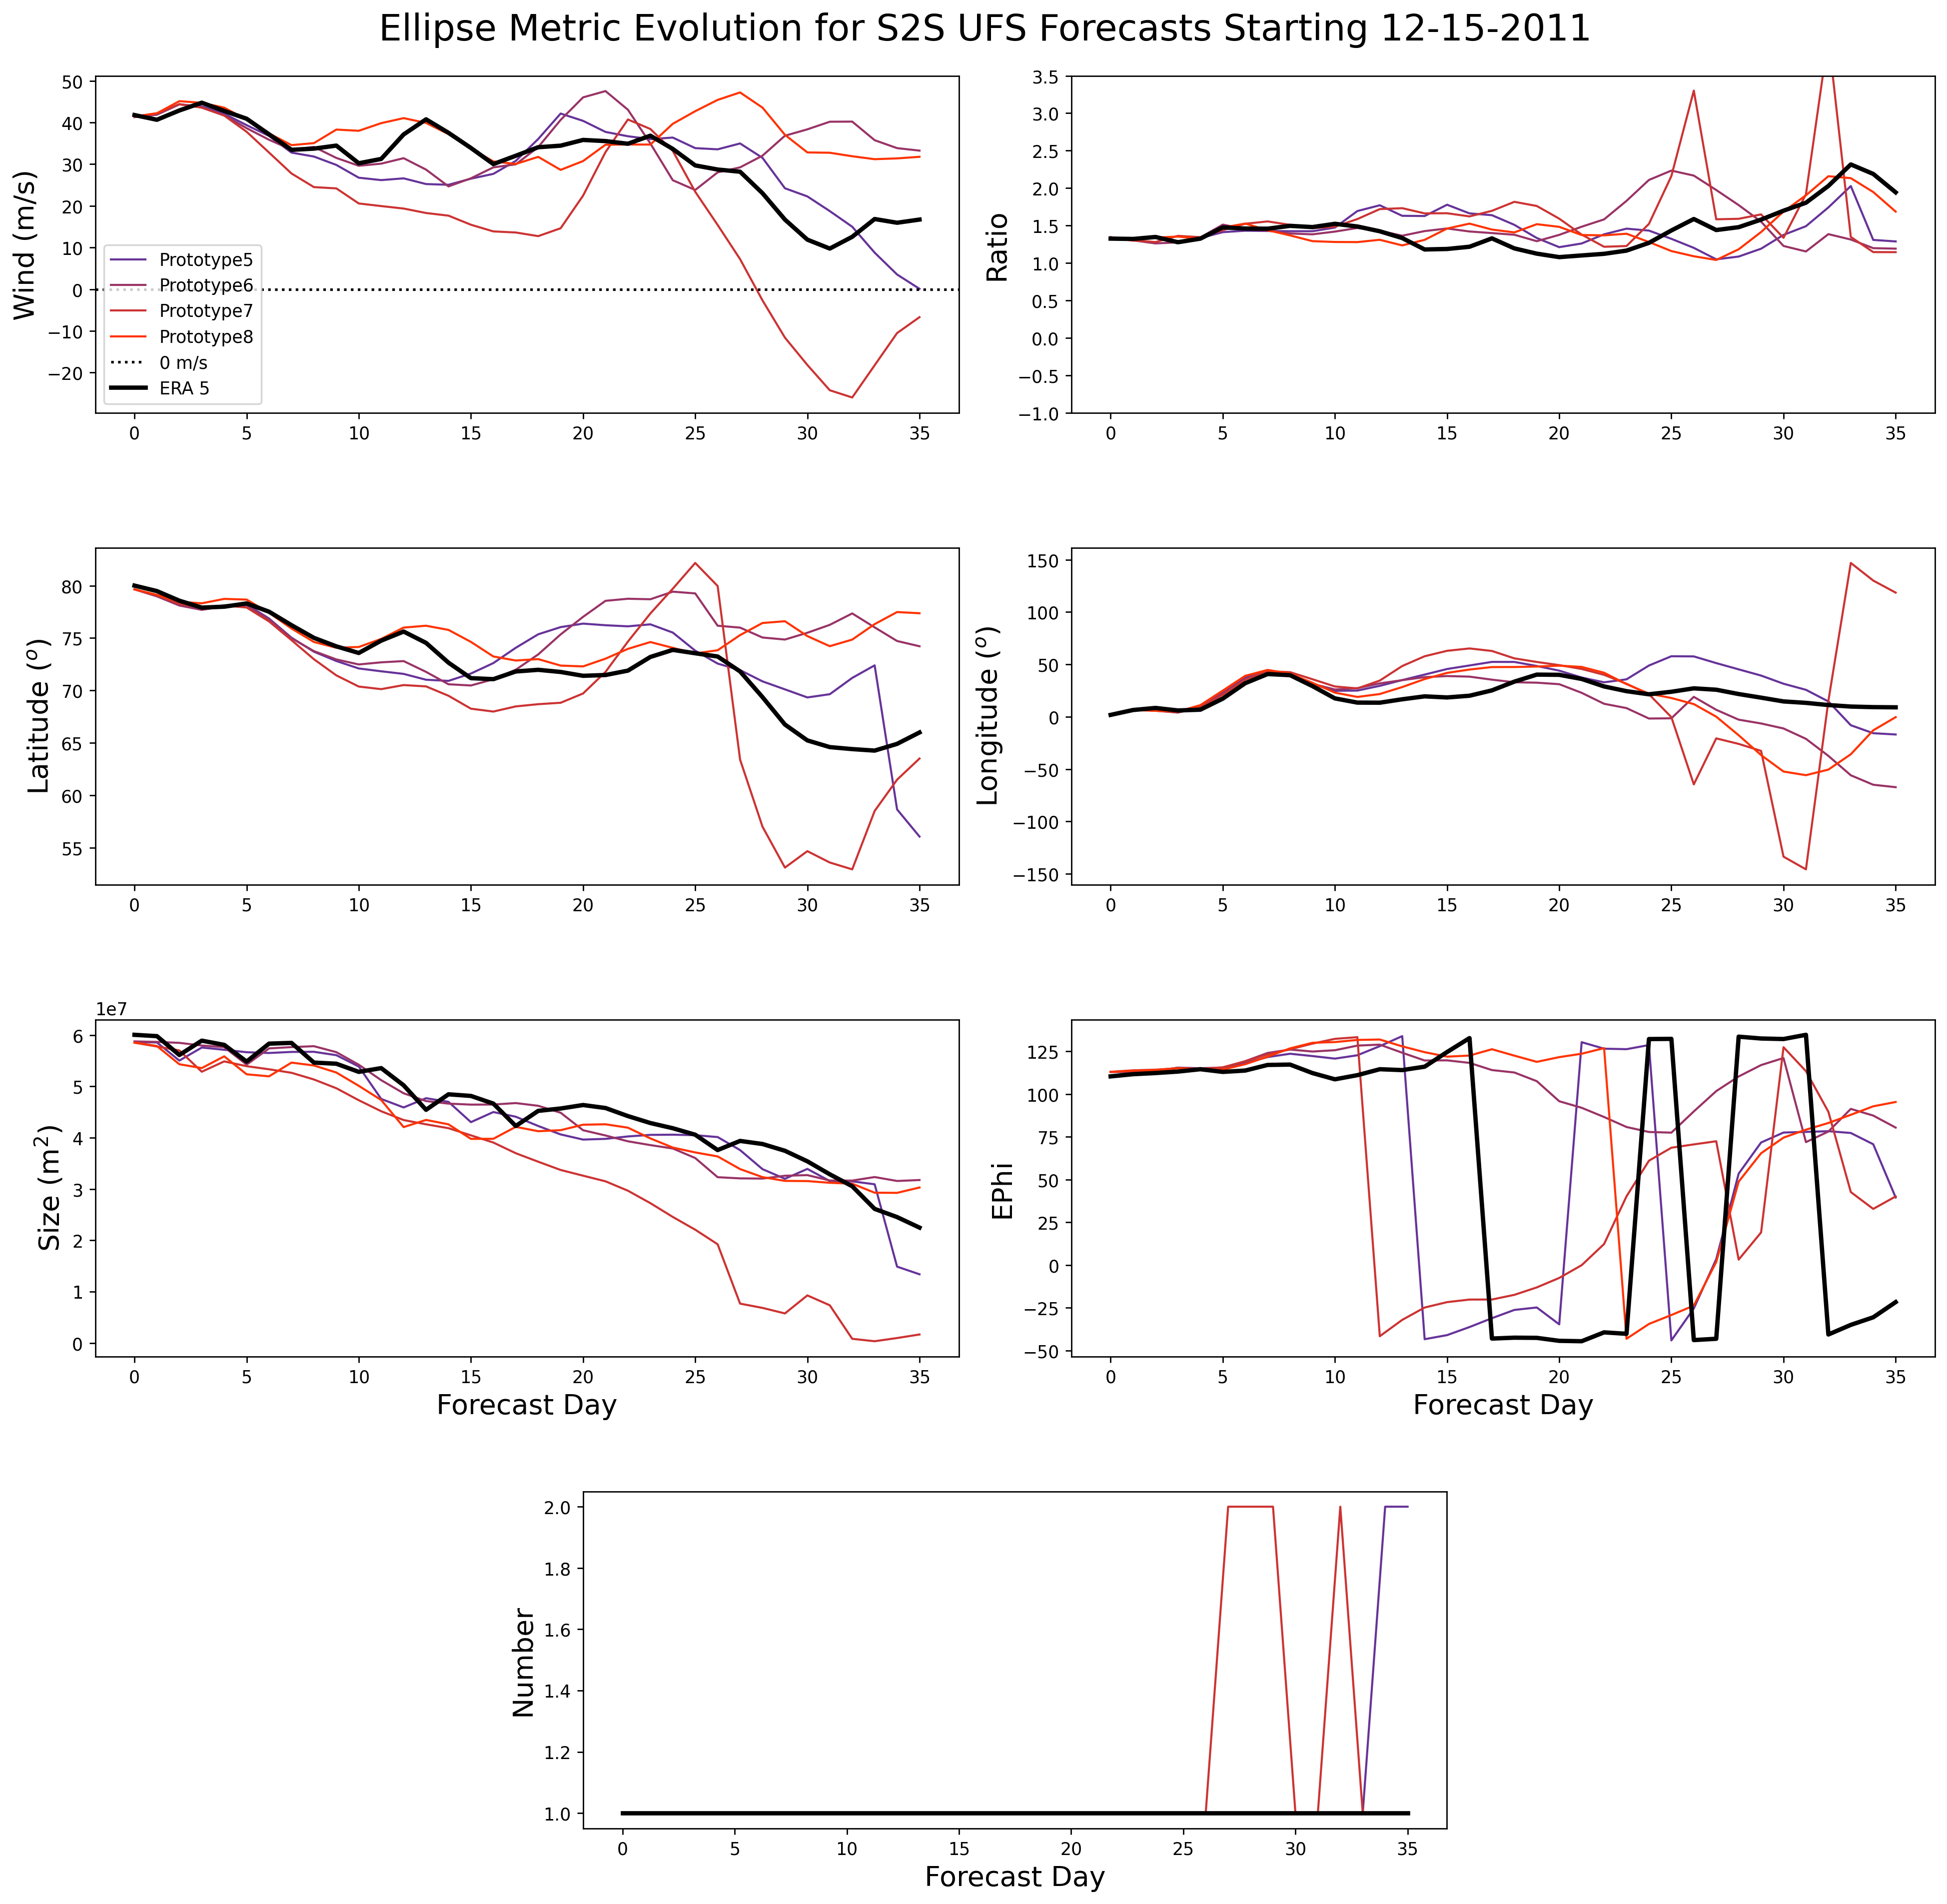

In [27]:
%matplotlib inline
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec

myLocator = mticker.MultipleLocator(5)

fig = plt.figure(figsize=(19,17), dpi=250)

# Use 4x4 grid for better control of spacing
gs = gridspec.GridSpec(4, 4, figure=fig, hspace=0.4, wspace=0.3)

# Top 6 subplots in a 3x2 layout, each using two columns
ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[1, 0:2])
ax4 = fig.add_subplot(gs[1, 2:4])
ax5 = fig.add_subplot(gs[2, 0:2])
ax6 = fig.add_subplot(gs[2, 2:4])

# Centered seventh subplot at the bottom, spanning columns 1 to 3
ax7 = fig.add_subplot(gs[3, 1:3])

fs = 16

for m in range(0, 5):
    if m == 4: 
        label = 'ERA 5'
        color = 'k'
        linewidth = 2.5
        ax1.axhline(y=0, color='k', linestyle=':', label="0 m/s")
    else: 
        label = str(prototype[m])
        colorR = (m + 2) / 5.
        color = (colorR, .2, 1 - colorR)
        linewidth = 1.2

    ax1.plot(forecast_days, wind10[m, :], color=color, label=label, linewidth=linewidth)
    ax2.plot(forecast_days, rat10[m, :], color=color, label=label, linewidth=linewidth)
    ax3.plot(forecast_days, cenlat10[m, :], color=color, label=label, linewidth=linewidth)
    ax4.plot(forecast_days, cenlon10[m, :], color=color, label=label, linewidth=linewidth)
    ax5.plot(forecast_days, size10[m, :], color=color, label=label, linewidth=linewidth)
    ax6.plot(forecast_days, ep10[m, :], color=color, label=label, linewidth=linewidth)

    # Example data for subplot 7 — replace with actual
    ax7.plot(forecast_days, num10[m, :], color=color, label=label, linewidth=linewidth)

# Axis labels & formatting
ax1.set_ylabel('Wind (m/s)', fontsize=fs)
ax2.set_ylabel('Ratio', fontsize=fs)
ax2.set_ylim(-1, 3.5)
ax3.set_ylabel('Latitude ($^o$)', fontsize=fs)
ax4.set_ylabel('Longitude ($^o$)', fontsize=fs)
ax5.set_ylabel('Size (m$^2$)', fontsize=fs)
ax6.set_ylabel('EPhi', fontsize=fs)
ax5.set_xlabel('Forecast Day', fontsize=fs)
ax6.set_xlabel('Forecast Day', fontsize=fs)
ax7.set_ylabel('Number', fontsize=fs)
ax7.set_xlabel('Forecast Day', fontsize=fs)

# Common formatting
#for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7]:
    #ax.axvline(x=forecast_days[6], color='k', linestyle='--')
    #ax.tick_params(axis='both', which='major', labelsize=fs)

ax1.legend(loc='lower left', fontsize='medium')

plt.suptitle("Ellipse Metric Evolution for S2S UFS Forecasts Starting 12-15-2011", fontsize=21)
plt.subplots_adjust(top=0.95)
#plt.tight_layout()
#plt.show()
plt.savefig("UFSMetric_Series.png")